In [37]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime

In [38]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [39]:
_C = CN()

_C.ROOT_PATH = ""
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 500
_C.IMAGE_H = 500
_C.MEAN = [0.4922, 0.4701, 0.4456]
_C.VAR = [0.2682, 0.2623, 0.2736]

In [40]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


In [41]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'clear', 'demoir', 'haze', 'rain']
5


decoding encoding labels

In [42]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [43]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
       
        if self.transform:
            img = self.transform(img) 
            
        label = img_path.split('/')[1].split('_')
        return img, encode_label(label) 

A function, that lists all images contained in the folder.

In [44]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [45]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(_C.MEAN, _C.VAR)])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor(),
                       T.Normalize(_C.MEAN, _C.VAR)])

In [46]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

17192
5281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([0., 1., 0., 0.])


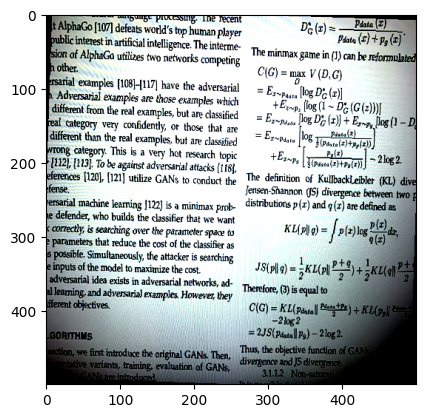

In [47]:
def show_example(img,label):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

show_example(*train_dataset[8000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: clear

tensor([0., 0., 0., 0.])


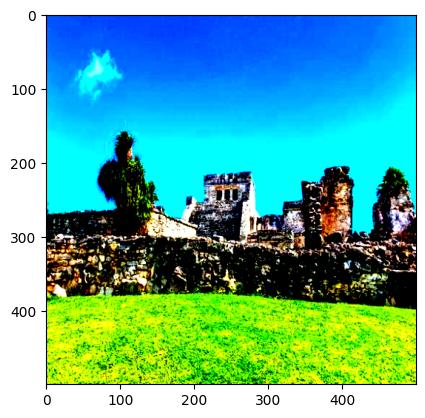

In [48]:
show_example(*val_dataset[1750])

In [49]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [50]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [51]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [52]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


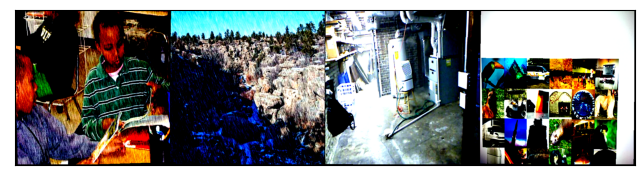

In [53]:
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [54]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [92]:
def binary_cross_entropy_modified(input, y):
    inp = input.clone()
    tar = y.clone()
    for i, pred in enumerate(tar):
        print(tar[i])
        print("****")
        print(inp[i])
    return -(pred.log()*y + (1-y)*(1-pred).log()).mean()

In [70]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        print(loss)
        del images
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        print(out)
        print("*")
        print(targets)
        score = F_score(out, targets)                # Calculate accuracy
        del images
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 'val_score': score.detach() }      


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}    

    def epoch_end(self, epoch, result):                     # display the losses
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [71]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [72]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [73]:
# checking up the shapes of the datas
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 500, 500])
torch.Size([4, 4])


In [74]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [75]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
        #input 3 x 500 x 500
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 500 x 500
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 500 x 500


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 120 x 120
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 120 x 120  


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 30 x 30
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 30 x 30


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 7 x 7
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 7 x 7


        self.classifier = nn.Sequential(nn.MaxPool2d(7), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 4    

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = torch.sigmoid(out)
        return out

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [76]:
class CustomModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=True)
        self.model.classifier = nn.Sequential(
          nn.Linear(1280, 512),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, 4)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        out = torch.sigmoid(out)
        return out

In [77]:
model = CustomModel().to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


803908

In [78]:
model

CustomModel(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 

In [79]:
#checking the shape of outputs that the model will produce before starting the training process
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 500, 500])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.5135, 0.4747, 0.5062, 0.4738],
        [0.5118, 0.4777, 0.5067, 0.4658]], device='cuda:0')


In [80]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(396361728, 72661504)

In [81]:
epochs = 10
max_lr = 0.001
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [82]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/661 [00:00<?, ?it/s]

tensor([[0.5176, 0.4754, 0.4931, 0.4763],
        [0.5145, 0.4763, 0.4933, 0.4735],
        [0.5209, 0.4779, 0.4914, 0.4732],
        [0.5176, 0.4767, 0.4924, 0.4747],
        [0.5172, 0.4740, 0.4943, 0.4768],
        [0.5165, 0.4739, 0.4924, 0.4774],
        [0.5182, 0.4762, 0.4935, 0.4745],
        [0.5187, 0.4744, 0.4949, 0.4741]], device='cuda:0')
*
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]], device='cuda:0')
tensor([[0.5212, 0.4791, 0.4953, 0.4726],
        [0.5178, 0.4775, 0.4959, 0.4741],
        [0.5202, 0.4739, 0.4969, 0.4711],
        [0.5206, 0.4734, 0.4961, 0.4707],
        [0.5147, 0.4800, 0.4922, 0.4762],
        [0.5196, 0.4783, 0.4947, 0.4730],
        [0.5178, 0.4783, 0.4996, 0.4744],
        [0.5187, 0.4763, 0.4984, 0.4750]], device='cuda:0')
*
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1

KeyboardInterrupt: 

In [66]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0003, train_loss: 0.2903, val_loss: 0.1316, val_score: 0.8055


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.1770, val_loss: 0.1190, val_score: 0.8113


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.1662, val_loss: 0.1373, val_score: 0.8072


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0010, train_loss: 0.1520, val_loss: 0.1602, val_score: 0.8115


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0008, train_loss: 0.1393, val_loss: 0.1744, val_score: 0.8131


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0006, train_loss: 0.1185, val_loss: 0.1792, val_score: 0.8130


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0004, train_loss: 0.1086, val_loss: 0.1666, val_score: 0.8106


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0002, train_loss: 0.1015, val_loss: 0.1402, val_score: 0.8154


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0000, train_loss: 0.0865, val_loss: 0.1678, val_score: 0.8131


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.0764, val_loss: 0.1799, val_score: 0.8128
CPU times: user 19min 10s, sys: 3min 48s, total: 22min 59s
Wall time: 36min 12s


In [67]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0003, train_loss: 0.0790, val_loss: 0.1563, val_score: 0.8118


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.1002, val_loss: 0.1636, val_score: 0.8145


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.1223, val_loss: 0.1906, val_score: 0.8088


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0010, train_loss: 0.1201, val_loss: 0.1400, val_score: 0.8138


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0008, train_loss: 0.1174, val_loss: 0.1590, val_score: 0.8138


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0006, train_loss: 0.1043, val_loss: 0.2082, val_score: 0.8091


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0004, train_loss: 0.0969, val_loss: 0.1713, val_score: 0.8074


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0002, train_loss: 0.0882, val_loss: 0.1904, val_score: 0.8131


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0000, train_loss: 0.0738, val_loss: 0.1874, val_score: 0.8158


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.0680, val_loss: 0.1846, val_score: 0.8144


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0003, train_loss: 0.0743, val_loss: 0.1827, val_score: 0.8165


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.0930, val_loss: 0.1656, val_score: 0.8127


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.1131, val_loss: 0.1922, val_score: 0.8149


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0010, train_loss: 0.1202, val_loss: 0.1784, val_score: 0.8117


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0008, train_loss: 0.1145, val_loss: 0.1343, val_score: 0.8161


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0006, train_loss: 0.1064, val_loss: 0.2184, val_score: 0.8082


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0004, train_loss: 0.0965, val_loss: 0.1993, val_score: 0.8116


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0002, train_loss: 0.0793, val_loss: 0.1819, val_score: 0.8174


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0000, train_loss: 0.0738, val_loss: 0.2054, val_score: 0.8168


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.0678, val_loss: 0.1946, val_score: 0.8168


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0003, train_loss: 0.0686, val_loss: 0.2241, val_score: 0.8138


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.0884, val_loss: 0.1495, val_score: 0.8156


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.1133, val_loss: 0.1886, val_score: 0.8147


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0010, train_loss: 0.1165, val_loss: 0.1386, val_score: 0.8054


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0008, train_loss: 0.1065, val_loss: 0.1384, val_score: 0.8153


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0006, train_loss: 0.0977, val_loss: 0.1732, val_score: 0.8149


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0004, train_loss: 0.0922, val_loss: 0.1574, val_score: 0.8170


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0002, train_loss: 0.0793, val_loss: 0.2067, val_score: 0.8164


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0000, train_loss: 0.0689, val_loss: 0.2020, val_score: 0.8161


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.0659, val_loss: 0.2066, val_score: 0.8130


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0003, train_loss: 0.0720, val_loss: 0.1553, val_score: 0.8183


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.0904, val_loss: 0.1533, val_score: 0.8134


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.1078, val_loss: 0.1553, val_score: 0.8111


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0010, train_loss: 0.1107, val_loss: 0.1305, val_score: 0.8153


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0008, train_loss: 0.1112, val_loss: 0.2037, val_score: 0.8144


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0006, train_loss: 0.1007, val_loss: 0.1772, val_score: 0.8107


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0004, train_loss: 0.0899, val_loss: 0.2104, val_score: 0.8173


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0002, train_loss: 0.0762, val_loss: 0.1958, val_score: 0.8182


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0000, train_loss: 0.0685, val_loss: 0.1900, val_score: 0.8175


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.0613, val_loss: 0.2091, val_score: 0.8165


In [68]:
evaluate(model, val_dl)

  0%|          | 0/661 [00:00<?, ?it/s]

{'val_loss': 0.20914240181446075, 'val_score': 0.8165106773376465}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([3.9395e-04, 9.9749e-01, 3.9869e-05, 1.3915e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)


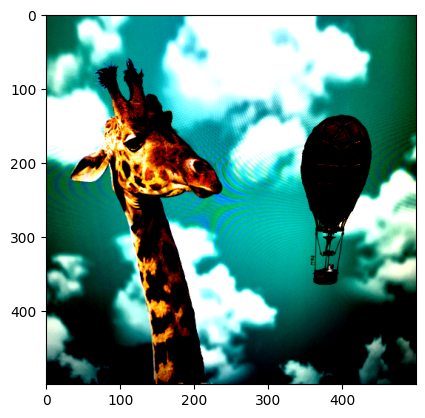

In [69]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_dataset[2890][0])

In [70]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

8
13
76
77
86
96
97
98
99
108
139
149
150
697
753
764
775
797
811
831
864
897
908
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1169
1170
1171
1172
1174
1175
1176
1177
1178
1179
1180
1181
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1201
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1235
1236
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1301
1302
1303
1304
1305
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
132

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([0.0450, 0.8852, 0.0054, 0.0283], device='cuda:0',
       grad_fn=<SelectBackward0>)


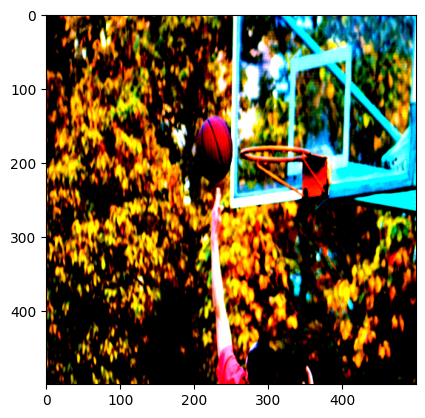

In [71]:
predict_single(val_dataset[2058][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([0., 1., 0., 0.])


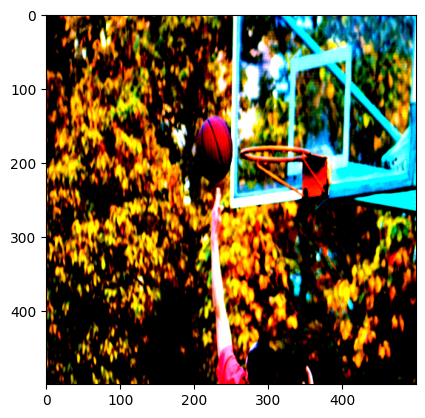

In [72]:
show_example(*val_dataset[2058])

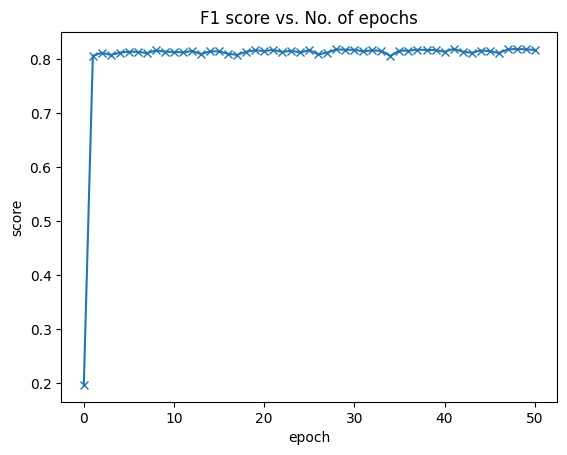

In [73]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

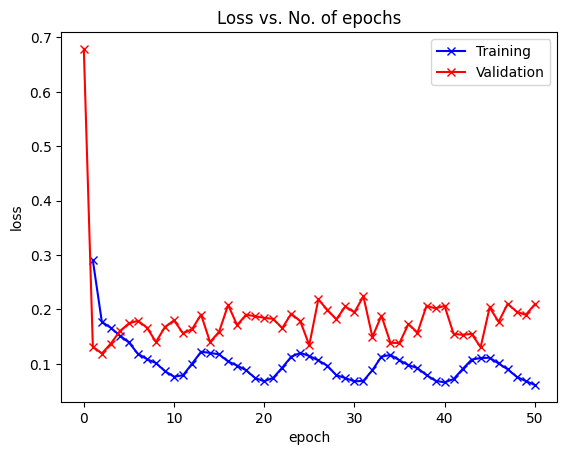

In [74]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

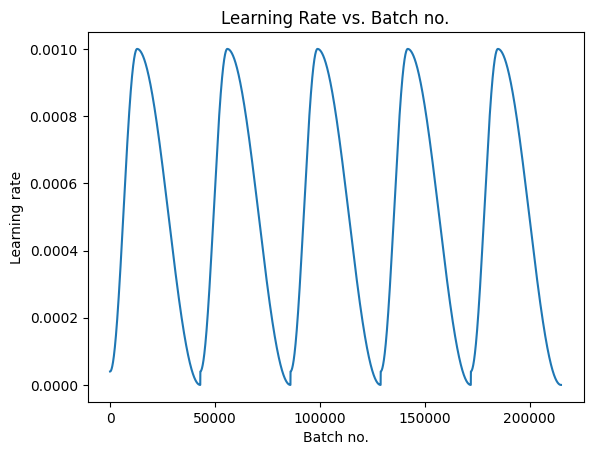

In [75]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [76]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([6.7765e-06, 1.5007e-06, 9.9997e-01, 1.8348e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: haze


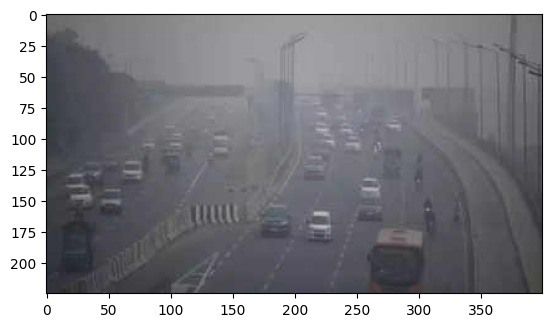

In [77]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([3.5387e-04, 9.9471e-01, 1.4557e-04, 4.7200e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: demoir


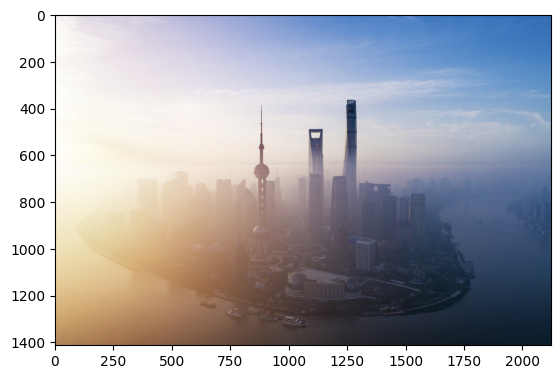

In [78]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([0.0201, 0.4801, 0.0011, 0.4755], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


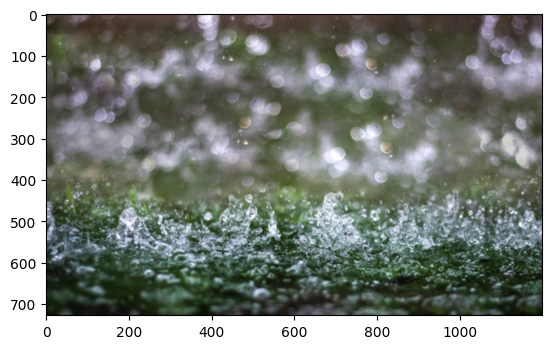

In [83]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([9.7402e-07, 2.3197e-07, 9.9999e-01, 3.9850e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)


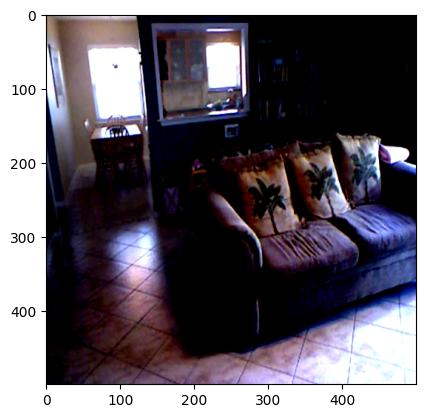

In [84]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_dataset[3280][0]) #checking out the predictions of some images from the validation dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([0., 0., 1., 0.])


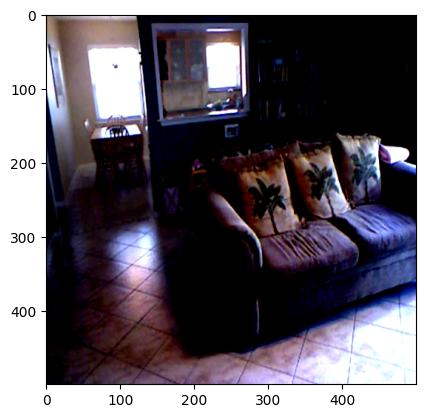

In [85]:
show_example(*val_dataset[3280]) #checking out the predictions of some images from the validation dataset.

In [82]:
PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()

In [260]:
inp = torch.Tensor([[0,1,0,1],
                   [1, 0, 1, 1]])
tar = torch.Tensor([[1,0,1,0],
                   [0.8, 0, 0, 0.5]])

In [267]:
res = F.binary_cross_entropy(inp, tar)

In [268]:
res

tensor(71.2500)

In [271]:
def BCE_custom(preds, targets):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, target in enumerate(targets):
        for j, val in enumerate(target):
            if val == 0:
                losses[i][j] = 0
    return losses.mean()

In [272]:
BCE_custom(inp, tar)

tensor(33.7500)